In [11]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# Try a more targeted postprocessing
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import re

from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.model.fish_ptm import ptm_config, ptm_tools
from stompy.model.suntans import sun_driver

In [3]:
import six
six.moves.reload_module(unstructured_grid)

<module 'stompy.grid.unstructured_grid' from '/home/rusty/src/stompy/stompy/grid/unstructured_grid.py'>

Overall Process
===

1. SUNTANS hydro runs
2. SUNTANS average output
3. ptm-formatted average output
4. PTM runs
5. Load data

The top-level query is something like *generate a map of concentrations for...*

filter on:
 - sources $x$
 - settling classes $y$
 - vertical positions $z$
 - horizontal positions $h$

weighted by

 - loading data 
 - age
 
mapped by one of ...

 - bounding box
 - put on hydro grid
 - put on regular grid

and possibly smoothed.

In [63]:
class Experiment:
    ptm_base_dir="/opt2/sfb_ocean/ptm/all_source_022a"
    sun_base_dir="/opt2/sfb_ocean/suntans/runs"
    hydro_timestamps=None
    
    def __init__(self):
        self.ptm_run_patt=os.path.join(self.ptm_base_dir,"chunk??","20??????")
        self.sun_patt=os.path.join(self.sun_base_dir,"merged_022_20??????")
        # does take a second
        self.init_hydro_timestamps()
    def __getstate__(self):
        d=self.__dict__.copy()
        try:
            del d['_memocache']
        except KeyError:
            print("No memocache to avoid")
        return d

    @memoize.imemoize()
    def run_paths(self):
        runs=glob.glob(self.ptm_run_patt)
        runs.sort()
        return runs
    @memoize.imemoize()
    def sun_paths(self):
        sun_runs=glob.glob(self.sun_patt)
        sun_runs.sort()
        return sun_runs
    @memoize.imemoize()
    def grid(self):
        """
        To minimize the amount of data required, just use
        the ptm average output, rather than loading the
        suntans input.
        """
        hydro_path=self.sun_paths()[0]
        ptm_ds=xr.open_dataset(os.path.join(hydro_path,"ptm_average.nc_0000.nc"))
        g=unstructured_grid.UnstructuredGrid.read_ugrid(ptm_ds,dialect='fishptm')
        ptm_ds.close() # safe?   
        return g
        
    def runs(self,criteria=None):
        result=[Run(path=p,experiment=self) 
                for p in self.run_paths()]
        if criteria is not None:
            result=[r for r in result if r.satisfies(criteria)]
        print("Narrowed to %d runs"%(len(result)))
        return result
    def runs_map_reduce(self,
                        map_func=lambda r: r,
                        reduce_func=lambda values: values,
                        criteria=None):
        return reduce_func([map_func(r) 
                            for r in utils.progress(self.runs(criteria=criteria),
                                                    msg="Runs %s")])
    def all_group_names(self):
        def mf(r):
            return r.group_names()
        def rf(lol):
            return [x for l in lol for x in l]
        return self.runs_map_reduce(map_func=mf,reduce_func=rf)
    def all_groups(self):
        def mf(r):
            grps=r.groups()
            return grps
        def rf(lol):    
            return [x for l in lol for x in l]
        return self.runs_map_reduce(map_func=mf,reduce_func=rf)
    def query_particles(self,criteria):
        """
        criteria: t_min, t_max ~ np.datetime64
          behaviors: list of strings, 'down5000','none',etc.
          sources: list of strings, shortened names.
        returns dataframe.
        """
        def query_run(run):
            print(f"query_particles.query_run({run.path})")
            return run.query_particles(criteria)
        
        particles=self.runs_map_reduce(criteria=criteria,
                                       map_func=query_run,
                                       reduce_func=lambda values: pd.concat(values))
        print("Adding z_bed")
        self.add_z_bed(particles)
        print("Adding z_surface")
        self.add_z_surface(particles)
        
        particles=self.select_by_vertical(particles,criteria)
        
        return particles
    
    def select_by_vertical(self,particles,criteria):
        """
        Return a subset of particles based on vertical filtering
        criteria: z_above_bed_max
                  z_below_surface_max
        (those would both take a positive value)
        """
        if 'z_above_bed_max' in criteria:
            sel=(particles['z']-particles['z_bed'])<criteria['z_above_bed_max']
            particles=particles.isel[sel,:]
        if 'z_below_surface_max' in criteria:
            sel=(particles['z_surface']-particles['z'])<criteria['z_below_surface_max']
            particles=particles.isel[sel,:]
        return particles
        
    def add_cells(self,df,fallback=True):
        """
        add a 'cell' column to the given dataframe, based on
        coordinates in df['x0'], df['x1'], and self.grid.
        if 'cell' already exists, do nothing.
        
        fallback: if True, particles that appear to fall outside the grid
        will get the closest cell.
        """
        if 'cell' in df.columns: return
        grid=self.grid()
        pnts=df[['x0','x1']].values
        cell=grid.points_to_cells(pnts)
        
        if fallback:
            missing=(cell<0)
            cell[missing]=grid.points_to_cells(pnts[missing],method='cells_nearest')
        
        df['cell']=cell
    def add_z_bed(self,df):
        self.add_cells(df)
        df['z_bed']=self.grid().cells['z_bed'][df['cell'].values]

    def open_hydro_ds(self,idx):
        return xr.open_dataset(os.path.join(self.sun_paths()[idx],
                                            "ptm_average.nc_0000.nc"))

    def init_hydro_timestamps(self):
        N=len(self.sun_paths())

        self.hydro_timestamps=np.zeros((N,2), "<M8[ns]") 
        # For starters, just scan the list to populate time stamps.
        for run_idx in range(N):
            ds=self.open_hydro_ds(run_idx)
            t=ds.Mesh2_data_time
            self.hydro_timestamps[run_idx,0]=t.values[0]
            self.hydro_timestamps[run_idx,1]=t.values[-1]
            ds.close()

    def time_to_hydro_index(self,t):
        N=self.hydro_timestamps.shape[0]
        # search on ending to avoid one-off correction.
        idx=np.searchsorted(self.hydro_timestamps[:,1],t).clip(0,N-1)
        assert t>=self.hydro_timestamps[idx,0]
        assert t<=self.hydro_timestamps[idx,1]
        return idx

    def add_z_surface(self,particles):
        """
        particles: dataframe with 'time' and 'cell'
        columns.
        adds 'z_surface' as a column with the elevation of the
        water surface at the particle time, linearly interpolated.

        It is possible but rare for particle['z'] values to be
        above z_surface (and below z_bed) but so far this does not
        appear to be a bug in this code. Rather, the cell mapping
        code is approximate when a point is not clearly within any
        cell polygon.  And in a few cases it appears the particle
        isn't in the domain.
        """
        p_time=particles['time'].values
        p_order=np.argsort(p_time)
        p_order_time=p_time[p_order]
        p_order_cell=particles['cell'].values[p_order]

        t_min=p_time.min()
        t_max=p_time.max()

        # def hydro_ds(self,t):
        idx0=self.time_to_hydro_index(t_min)
        idxN=self.time_to_hydro_index(t_max)

        # hold the results, constructed in time order
        p_order_eta=np.nan*np.zeros(len(particles),np.float32)

        def extract_eta(ds,p_time,p_cell):
            """
            ds: dataset for a chunk of a hydro run
            p_time: times, must fall within ds
            p_cell: cells corresponding to the particle times

            returns: eta values interpolated from ds at the given times, and
            extracted for the given cells.
            """
            ds_time=ds.Mesh2_data_time.values
            p_eta=np.nan*np.ones(len(p_time))
            # waterlevel is instantaneous, and we can linearly interpolate
            # between timesteps. Particles are output at 0.25h or 0.5h intervals,
            # so it doesn't take too many different interpolations.
            for t_grp,part_idxs in utils.progress(utils.enumerate_groups(p_time)):
                tA=ds_time.searchsorted(t_grp)
                assert tA<len(ds_time),"Seems to step off the end of the data"
                # For an exact match, tA is the step we want.
                if ds_time[tA]==t_grp: # good
                    eta=ds.Mesh2_sea_surface_elevation.isel(nMesh2_data_time=tA).values
                else:
                    # Linearly interpolate:
                    assert tA+1<len(ds_time)
                    etaA=ds.Mesh2_sea_surface_elevation.isel(nMesh2_data_time=tA).values
                    etaB=ds.Mesh2_sea_surface_elevation.isel(nMesh2_data_time=tA+1).values
                    theta=(t_grp-ds_time[tA])/(ds_time[tA+1] - ds_time[tA])
                    assert theta>=0
                    assert theta<=1.0
                    print(f"Theta: {theta}")
                    eta=(1-theta)*etaA[0,:] + theta*etaB
                p_eta[part_idxs]=eta[p_cell[part_idxs]]
            return p_eta

        for idx in range(idx0,idxN+1):
            # Iterate over hydro runs
            # Bad naming of variables.
            idx_start,idx_stop=self.hydro_timestamps[idx]

            # Edge cases?
            #  for particles times [x,x,x,y,y,y,z,z,z]
            #  and idx_start=x, idx_stop=z
            #  particle time falls on the first step of output:
            #  then order_start will 
            order_start=p_order_time.searchsorted(idx_start,side='left')
            order_stop =p_order_time.searchsorted(idx_stop,side='right')
            if order_start==order_stop:
                print("Empty slice")
                continue

            part_slc=slice(order_start,order_stop)
            assert np.all( p_order_time[part_slc]>=idx_start )
            assert np.all( p_order_time[part_slc]<=idx_stop  )

            print(f"Would load {idx}")

            ds=self.open_hydro_ds(idx)

            eta_slc=extract_eta(ds,
                                p_order_time[part_slc],
                                p_order_cell[part_slc])
            p_order_eta[part_slc]=eta_slc
        assert np.all(np.isfinite(p_order_eta))
        # Undo the sort to assign back to the particles:
        particles['z_surface']=p_order_eta[np.argsort(p_order)]

    @memoize.imemoize()
    def load_data(self):
        """
        Load loading data, return an xr.Dataset that maps
        sources and behaviors to concentrations in particles/liter
        """
        loads_orig=xr.open_dataset("../loads/plastic_loads-7classes-v05.nc")

        # And the per-watershed scaling factor
        storm_scales=pd.read_csv("../loads/stormwater_concs-v02.csv")

        # Get rid of the extra fields in loads -- otherwise we have to fabricate
        # them for the watersheds
        loads=loads_orig.copy()

        for fld in ['n_blank_particles','n_blank_samples','blank_rate',
                    'total_volume','n_samples','count_w_s','count_no_w_s',
                    'conc_raw','conc_noclip','conc_blank','blank_derate']:
            del loads[fld]

        # Extend loads_orig with storm_scales
        storm_conc=loads_orig['conc'].sel(source='stormwater')
        storm_conc_net=storm_conc.values.sum()
        storm_conc_net # 8.50 particles/l

        watershed_conc=np.zeros( (len(storm_scales),loads_orig.dims['category'],loads_orig.dims['w_s']))
        # bui(source, category, w_s) 
        for storm_i,storm_scale in storm_scales.iterrows():
            watershed_conc[storm_i,:,:] = storm_conc.values * storm_scale['net_coeff_scaled'] / storm_conc_net

        watershed_loads=xr.Dataset()
        watershed_loads['source']=('source',),storm_scales['source']
        watershed_loads['conc']=('source','category','w_s'),watershed_conc
        watershed_loads['source_pathway']=('source',),['stormwater']*len(storm_scales)
        watershed_loads['pathway']=loads_orig['pathway']

        loads=xr.concat( (loads,watershed_loads), dim='source')

        # drop 'stormwater' to catch potential bugs later
        return loads.isel(source=(loads.source!='stormwater'))

    @memoize.imemoize()
    def bc_ds(self):
        """ Extract the relevant parts of the BC data, return as a single dataset
        """
        compiled_fn=os.path.join(self.sun_paths()[0],'bc_extracted_v4.nc')

        if not os.path.exists(compiled_fn):
            self.extract_bc_ds(compiled_fn)
        ds=xr.open_dataset(compiled_fn)
        return ds

    def extract_bc_ds(self,compiled_fn):
        dss=[]
        dss_orig=[] # for closing

        for run_path in self.sun_paths():
            # only care about point sources, and river inflows (i.e. ignore
            # ocean flux BCs, and any freesurface BCs
            model=sun_driver.SuntansModel.load(run_path)
            ds=model.load_bc_ds()
            dss_orig.append(ds)
            ti_start,ti_stop=np.searchsorted(ds.time.values,[model.run_start,model.run_stop])
            ds=ds.isel(Nt=slice(ti_start,ti_stop+1))

            for extra in ['T','S','h','boundary_h','boundary_w','boundary_T',
                          'boundary_u','boundary_v','z',
                          'point_S','point_T','cellp','xv','yv','uc','vc','wc']:
                if extra in ds: del ds[extra]

            type2_sel= ds['boundary_S'].isel(Nk=0,Nt=0)==0.0
            ds=ds.isel(Ntype2=type2_sel)
            del ds['boundary_S']
            dss.append(ds)

        trim_dss=[]
        for ds in dss:
            if not trim_dss:
                trim_dss.append(ds)
                continue
            else:
                t_sel=ds.time.values>trim_dss[-1].time.values[-1]
                if t_sel.sum():
                    trim_dss.append(ds.isel(Nt=t_sel))
                else:
                    log.warning("BC dataset had no useful times?")

        assert len(trim_dss)
        ds=xr.concat(trim_dss,dim='Nt',data_vars='different')
        # somehow there is some 1e-9 difference between xe 
        for v in ['xe','ye']:
            if 'Nt' not in ds[v].dims: continue
            # make sure it's not a terrible issue
            assert ds[v].std(dim='Nt').max()<1.0
            ds[v]=ds[v].isel(Nt=0)

        # A bit goofy, but try to avoid a race condition, short of
        # utilizing a real lock.
        tmp_fn=compiled_fn+"."+str(os.getpid())
        ds.to_netcdf(tmp_fn)
        if not os.path.exists(compiled_fn):
            os.rename(tmp_fn,compiled_fn)
        else:
            log.warning("Things got racy while transcribing BC data")
            os.unlink(tmp_fn)

        [ds.close() for ds in dss_orig]

    @memoize.imemoize()
    def source_Qdata(self,source):
        """
        returns a time series DataArray for the
        respective source's flow rate.
        This step also clamps flows to be non-negative.
        """
        bc_ds=self.bc_ds()

        # get a flow time series for this specific group
        try:
            seg_i=list(bc_ds.seg_name.values).index(source)
            Q_time_series=bc_ds.set_coords('time')['boundary_Q'].isel(Nseg=seg_i)
        except ValueError:
            # point sources are labeled as srcNNN
            pnt_i=int(source.replace('src',''))
            Q_time_series=bc_ds.set_coords('time')['point_Q'].isel(Npoint=pnt_i)
            
        return Q_time_series.clip(0.0)
        
class Run:
    experiment=None
    path=None
    def __init__(self,**kw):
        utils.set_keywords(self,kw)
    def group_names(self):
        bin_out_fns=glob.glob(os.path.join(self.path,"*_bin.out"))
        group_names=[os.path.basename(p).replace('_bin.out','') for p in bin_out_fns]
        return group_names
    @memoize.imemoize()
    def groups(self):
        return [Group(run=self,name=name) for name in self.group_names()]
    def satisfies(self,criteria):
        if 't_min' in criteria and self.t_max()<criteria['t_min']:
            return False
        if 't_max' in criteria and self.t_min()>criteria['t_max']:
            return False
        return True
    @memoize.imemoize()
    def ptm_config(self):
        return ptm_config.PtmConfig.load(self.path)
    def t_max(self):
        "Maximum time of particle outputs for the run."
        return self.ptm_config().end_time
    def t_min(self):
        "Minimum time of particle outputs."
        # relies on knowing that all groups follow the same start/end 
        # within a run
        return self.groups()[0].t_min()
    def query_particles(self,criteria):
        results=[g.query_particles(criteria)
                 for g in utils.progress(self.groups(),msg="  Groups %s")
                 if g.satisfies(criteria)]
        if results:
            df=pd.concat(results)
            df['run']=self.path
            return df
        else:
            return pd.DataFrame()

class Group:
    run=None
    name=None
    def __init__(self,**kw):
        utils.set_keywords(self,kw)
        m=re.match(r'(.*)_((up|down|none)\d*)_rel(\d+)',self.name)
        self.source,self.behavior,self.release_date=m.group(1),m.group(2),m.group(4)
    def satisfies(self,criteria):
        if 'sources' in criteria and self.source not in criteria.sources:
            return False
        if 't_min' in criteria and self.t_max() < criteria['t_min']:
            return False
        if 't_max' in criteria and self.t_min() > criteria['t_max']:
            return False
        if 'behaviors' in criteria and self.behavior not in criteria.behaviors:
            return False
        return True
    @memoize.imemoize()
    def t_max(self):
        return self.run.t_max()
    @memoize.imemoize()
    def t_min(self):
        release_log_fn=os.path.join(self.run.path,self.name+".release_log")
        with open(release_log_fn,'rt') as fp:
            rel_date,rel_time=fp.readline().strip().split()[-2:]
        return np.datetime64(rel_date+" "+rel_time)
    # Try non-instance memoize to manage cache better.
    @memoize.memoize(lru=20)
    def ptm_bin(self):
        return ptm_tools.PtmBin(fn=os.path.join(self.run.path,self.name+"_bin.out"))
    @memoize.imemoize()
    def release_log(self):
        fn=os.path.join(self.run.path,self.name+".release_log")
        # df_rel=ptm_tools.release_log_dataframe(fn=fn)
        rel=ptm_tools.ReleaseLog(fn)
        df_rel=rel.data
        # release has id and gid. So far they are always the same
        # Trust, but verify.
        assert np.all(df_rel['id'].values==df_rel['gid'].values),"Invariant check"
        return rel
    
    def query_particles(self,criteria):
        # Could be faster by using index instead of bin file
        pbf=self.ptm_bin()
        times=np.array( [utils.to_dt64(t) for t in pbf.time] )
        sel=np.ones(len(times),np.bool8)
        if 't_min' in criteria:
            sel=sel&(times>=criteria['t_min'])
        if 't_max' in criteria:
            sel=sel&(times<=criteria['t_max'])

        all_particles=[]
        for ts in np.nonzero(sel)[0]:
            datenum,particles=pbf.read_timestep(ts)
            t=utils.to_dt64(datenum)
            #particles=self.filter_particles(particle,criteria)
            #df=pd.DataFrame(particles) # Can't deal with vectors
            df=pd.DataFrame()
            df['id']=particles['id']
            df['x0']=particles['x'][:,0]
            df['x1']=particles['x'][:,1]
            df['x2']=particles['x'][:,2]
            df['active']=particles['active']
            # Avoid keeping all this memmap'd data around
            del particles
            df['time']=t
            all_particles.append(df)
        if len(all_particles):
            df=pd.concat(all_particles)
            df['group']=self.name
            
            # Assign release times
            # If this is slow, could verify that release_log index 
            # is dense, and do this in numpy
            df_rel=self.release_log().data.set_index('id') # id vs gid?
            rel_times=df_rel.loc[ df['id'].values,'date_time']
            df['rel_time']=rel_times.values
            
            self.add_mp_count(df,criteria)
            
            return df
        else:
            return pd.DataFrame()
    def w_s(self):
        w_s_map={'down50000':0.05,
                 'down5000':0.005,
                 'down500':0.0005,
                 'none':0.0,
                 'up500':0.0005,
                 'up5000':0.005,
                 'up50000':0.05}
        return w_s_map[self.behavior]
    
    # For a subset of the source names in the PTM setup,
    # map them to the name used in the loading data
    source_ptm_to_load={
        'cccsd':'CCCSD',
        'sunnyvale':'SUNN',
        'fs':'FSSD',
        'palo_alto':'PA',
        'san_jose':'SJ',
        'src000':'EBDA',
        'src001':'EBMUD',
        'src002':'SFPUC',
        # These shouldn't be used, but including just to be sure
        # that if they somehow show up, they won't contaminate
        # stormwater.
        'SacRiver':'DELTA',
        'SJRiver':'DELTA'
    }

    def load_conc(self,categories='all'):
        """
        Concentration for this particle group, in particles/liter.
        categories: 'all','nonfiber', a list of category names,
        or a single category name
        """
        load_data=self.run.experiment.load_data()
        # source: e.g. 'San_Lorenzo_C'
        if self.source in self.source_ptm_to_load:
            load_source=self.source_ptm_to_load[self.source]
        else:
            load_source=self.source
            
        conc_over_category=load_data['conc'].sel(source=load_source,w_s=self.w_s())
        if categories=='all':
            conc=conc_over_category.values.sum()
        elif categories=='nonfiber':
            sel=conc_over_category.category!='Fiber'
            conc=conc_over_category.isel(category=sel).values.sum()
        else:
            conc=conc_over_category.sel(category=categories).values.sum()
        return conc
    
    def Qdata(self):
        return self.run.experiment.source_Qdata(self.source)

    def volume_per_particle(self,particles):
        """
        Need particles/per time for release time t
        and volume/time for source at time t.
        Returns array with volume per particle for each of the given particles.

        Some parts of this aren't really group specific, could be moved elsewhere.
        """
        # Sanity check:
        # this is giving about 60m3/particle.
        # I know there are 10 particles/hr released.
        # so that's saying that San_Lorenzo_C[reek] has
        # a flow of 600m3/hour, or 0.17 m3/s in June 2017.
        # USGS measured is 6-8 cfs, which is order 0.2 m3/s.
        # Good.

        # pbf=run.open_binfile(group)
        rel=self.release_log()

        # Record the data from release_log
        release=rel.intervals
        # release['group_id']=group_id
        # release['epoch']=(release['time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

        # Ham-handed fix up of truncated release logs.
        typical_count=int( np.median( release['count'] ) )
        bad=release['count']!=typical_count
        # a little bit smart -- only step in when it's the last step that's
        # different.
        if (not np.any(bad[:-1])) and bad[-1]:
            print("Yikes - release_log might be missing some particles.")
            print("  Changing reported count of %d to %d"%(release['count'].values[-1],
                                                           typical_count))
            print("  And punting on id_max,gid_max")
            release.loc[bad,'count']=typical_count
            # careful of inclusive indexes
            release.loc[bad,'id_max']=release.loc[bad,'id_min']+typical_count-1
            release.loc[bad,'gid_max']=release.loc[bad,'gid_min']+typical_count-1

        # add in volume information.
        Qdata=self.Qdata() 
        Qvalues=Qdata.values
        Qpart=np.zeros(len(particles),np.float64)
        Qpart[:]=np.nan # for safety
        # This could be sped up since the same time will appear many times
        # in particles. Does it matter?
        for t,part_idxs in utils.enumerate_groups(particles['rel_time'].values):
            Qidx=np.searchsorted(Qdata.time.values,t)
            Qpart[part_idxs]=Qvalues[Qidx]

        grp_hour_per_rel=(release['time'].values[1] - release['time'].values[0])/np.timedelta64(3600,'s')

        # m3/s * s/hour * hour/release / (particles/release) => m3/particle
        part_volume=Qpart*3600 * grp_hour_per_rel/typical_count
        return part_volume # m3/particle
    def add_mp_count(self,particles,criteria):
        category=criteria.get('category','all')
        mp_per_liter=self.load_conc(category)

        # how many m3 of effluent does each computational particle
        # represent?
        m3_per_particle=self.volume_per_particle(particles)
        #                  mp_count / m3   *   m3 / particle
        mp_per_particle=mp_per_liter * 1e3 * m3_per_particle
        particles['mp_count']=mp_per_particle
        

experiment=Experiment()
runs=experiment.runs()
print(f"{len(runs)} runs found")
groups=experiment.all_groups()
print(f"{len(groups)} groups total")


Narrowed to 124 runs
124 runs found
Narrowed to 124 runs
10633 groups total


In [ ]:
%%time
criteria=dict(t_min=np.datetime64("2017-06-28 01:00"),
              t_max=np.datetime64("2017-06-28 02:00"),
              category='all',z_below_surface_max=0.20,
              behavior='up5000')

particles=experiment.query_particles(criteria=criteria)
print(f"Found {len(particles)} particles")
# Promising:
# Can query 1M particles in 4s. That's 4h of one run.
# In this case, 8 runs satisfy the time slice.
# Cold start, queries 4.5M particles over 8 runs in 70s.
# Warm start, 28s.

Narrowed to 4 runs
query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk00/20170620)


INFO:utils:  Groups 74/91
INFO:utils:Runs 1/4


query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk01/20170620)


INFO:utils:  Groups 74/91
INFO:utils:Runs 2/4


query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk02/20170620)


<IPython.core.display.Javascript object>


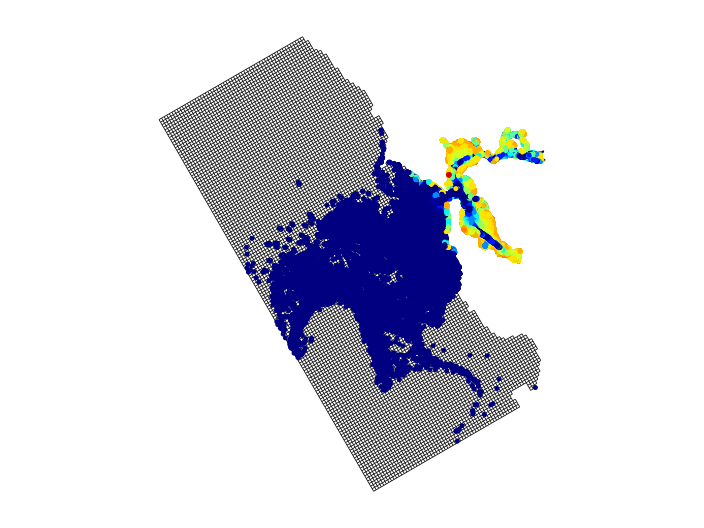

In [12]:
fig,ax=plt.subplots()
experiment.grid().plot_edges(color='k',lw=0.5,ax=ax)
sel=slice(None,None,20)
scat=ax.scatter(particles['x0'].values[sel],
           particles['x1'].values[sel], 
           5,particles['z_bed'].values[sel],
           cmap='jet',zorder=2)
scat.set_clim([-20,0])
ax.axis('tight')
ax.axis('equal')
ax.axis('off')
fig.tight_layout()

In [13]:
age=(particles['time']-particles['rel_time'])/np.timedelta64(1,'s')

<IPython.core.display.Javascript object>


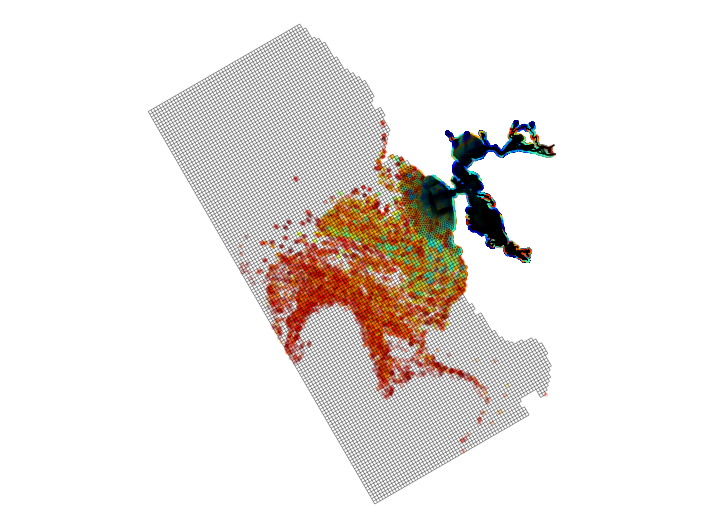

In [15]:
fig,ax=plt.subplots(1,1)
experiment.grid().plot_edges(color='k',lw=0.5,alpha=0.5,ax=ax)
ax.set_position([0,0,1,1])
ax.axis('off')
ax.axis('tight')
ax.axis('equal')

sel=slice(None,None,20)
x=particles['x0']
y=particles['x1']
ax.scatter(x[sel],y[sel],4,age[sel],alpha=0.2,cmap='jet')

Status
--

Reasonable performance reading data single-threaded.

Next steps:

1. Have Experiment or Run filter on z
2. Have Group (or maybe a Source class) add weighting by forcing data.
3. How hard would it be to parallelize at some level?  Don't do this too
   early, but take a look in case it's easy.
4. Recreate some of the figures from before, including on-grid smoothing.
5. Pull out manta samples as before. Maybe skip putting it on the grid, just
   query a radius.

In [32]:
# Weighting w.r.t. source, release time, behavior
# This should be implemented by Group
group=groups[0]

print("Source:",group.source)
print("Behavior:",group.behavior)
print("Group name:",group.name)


grp_particles=group.query_particles(criteria)
len(grp_particles)

# HERE -
# Groups now have load_conc(category) => particles/l
# and volume_per_particle(particles) => m3/particle

group.load_conc('Fragment')

# Sanity check:
# this is giving about 60m3/particle.
# I know there are 10 particles/hr released.
# so that's saying that San_Lorenzo_C[reek] has
# a flow of 600m3/hour, or 0.17 m3/s in June 2017.
# USGS measured is 6-8 cfs, which is order 0.2 m3/s.
# Good.

volumes=group.volume_per_particle(grp_particles)

mp_count=volumes*

Source: San_Lorenzo_C
Behavior: down50000
Group name: San_Lorenzo_C_down50000_rel20170620


0.12110621216403998

In [42]:
group.load_conc('Fiber')

0.0

In [33]:
grp_particles

,id,x0,x1,x2,active,time,group,rel_time
0,1,568375.249613,4.168915e+06,-7.842241,1,2017-06-28 01:00:00,San_Lorenzo_C_down50000_rel20170620,2017-06-20 00:00:00
1,2,573576.778205,4.169449e+06,-5.274128,1,2017-06-28 01:00:00,San_Lorenzo_C_down50000_rel20170620,2017-06-20 00:00:00
2,3,569643.800618,4.169724e+06,-6.616636,1,2017-06-28 01:00:00,San_Lorenzo_C_down50000_rel20170620,2017-06-20 00:00:00
3,4,569076.087298,4.169700e+06,-7.179398,1,2017-06-28 01:00:00,San_Lorenzo_C_down50000_rel20170620,2017-06-20 00:00:00
4,5,572828.717290,4.169746e+06,-5.460071,1,2017-06-28 01:00:00,San_Lorenzo_C_down50000_rel20170620,2017-06-20 00:00:00
...,...,...,...,...,...,...,...,...
1945,1946,573761.530365,4.169654e+06,-4.110892,1,2017-06-28 02:00:00,San_Lorenzo_C_down50000_rel20170620,2017-06-28 02:00:00
1946,1947,573744.288195,4.169672e+06,-4.110892,1,2017-06-28 02:00:00,San_Lorenzo_C_down50000_rel20170620,2017-06-28 02:00:00
1947,1948,573727.046025,4.169689e+06,-4.110892,1,2017-06-28 02:00:00,San_Lorenzo_C_down50000_rel20170620,2017-06-28 02:00:00
1948,1949,573709.803855,4.169707e+06,-4.110892,1,2017-06-28 02:00:00,San_Lorenzo_C_down50000_rel20170620,2017-06-28 02:00:00


In [38]:
600/3600.

0.16666666666666666

In [100]:

Qdata=group.get_Qdata()

INFO:root:Restart appears to have 1 subdomains
INFO:root:Restart appears to have 1 subdomains
INFO:root:Restart appears to have 1 subdomains
INFO:root:Restart appears to have 1 subdomains
INFO:root:Restart appears to have 1 subdomains
INFO:root:Restart appears to have 1 subdomains
INFO:root:Restart appears to have 1 subdomains
INFO:root:Restart appears to have 1 subdomains
INFO:root:Restart appears to have 1 subdomains
INFO:root:Restart appears to have 1 subdomains
INFO:root:Restart appears to have 1 subdomains
INFO:root:Restart appears to have 1 subdomains
INFO:root:Restart appears to have 1 subdomains
INFO:root:Restart appears to have 1 subdomains
INFO:root:Restart appears to have 1 subdomains
INFO:root:Restart appears to have 1 subdomains
INFO:root:Restart appears to have 1 subdomains
INFO:root:Restart appears to have 1 subdomains
INFO:root:Restart appears to have 1 subdomains
INFO:root:Restart appears to have 1 subdomains
INFO:root:Restart appears to have 1 subdomains
INFO:root:Res

In [55]:
# where is a pthread lock coming in?
#groups[0].run.experiment.__dict__
# something in the experiments memocache.

import pickle
exp=groups[0].run.experiment

for k in exp.__dict__.keys():
    print(k)
    pickle.dumps(exp.__dict__[k])

ptm_run_patt
sun_patt
_memocache


TypeError: can't pickle _thread.lock objects